In [ ]:
# coding=utf-8
# Copyright 2023 Frank Latos AC8P
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#
# Much appreciation to the Pymoo project for providing the optimization framework used herein:
#
# pymoo: Multi-objective Optimization in Python
# https://github.com/anyoptimization/pymoo
# https://pymoo.org/index.html
#


# Design Optimization with Constraints, Part 2:  Mixed Parameter Types


A repeat of the wire-length-minimization problem from the previous notebook, but with one added parameter: an (integer) variable representing the number of parallel wires in the 'cage' section of the element.

The design parameters are now:
* 'length'      overall length    (float)
* 'angle'       vee angle         (float)
* 'cage_frac'   length of 'cage' portion as fraction of overall length    (float)
* 'par_wires'   number of parallel wires in cage      (integer)


In [22]:


import numpy as np
from pymoo.core.problem import Problem
from necutil import nec5_sim_stdio3, make_linear_element, gen_nec5_str, plot_vswr_2
from necutil import wire_ant_visualize, rot_x, translate, make_cage_element, total_wire_len

# 
# Basically unchanged from previous version -
#  the way we're defining our variables has changed (see next section)
#
class DipoleConstrainedSingleOptMixedProblem(Problem):
    
    # Added 'n_ieq_constr' parameter: number of inequality constraints
    def __init__(self, variables, n_ieq_constr, segs_per_m, radius, f_min, f_max, z, f_num=9, **kwargs):

        super().__init__(vars=variables,
                         n_obj=1,
                         n_ieq_constr=n_ieq_constr,
                         **kwargs)


        self.f_min = f_min              # Frequency band of interest: min, max, # of points
        self.f_max = f_max
        self.f_num = f_num        
        self.freqs = np.linspace(f_min, f_max, num=f_num)       # Freqs of interest as an array
        self.f_center = np.mean([f_min,f_max])                  # Center freq
        self.z0 = 50                    # TL impedance
        self.z = z                      # z dimension (height of antenna)
        self.segs_per_m = segs_per_m    # NEC secgents per meter 
        self.radius = radius            # Wire radius (m)
        
        # NEC5 design deck template
        # GX: mirror across xz plane
        # EX: feedpoint specified as tag=1, segment=1, near end (1)
        # GD: Some typical MININEC ground parameters
        self.necpre = 'CE Dipole\n'             # Obligatory comment line
        self.necpost = f"""GX 100 010
GE 1 0
GD 0 0 0 0 13 0.005 0 0
EX 4 1 1 1 1.0 0.0
FR 0 {f_num} 0 0 {f_min} {(f_max-f_min)/(f_num-1)}
XQ 0
EN
"""
 
    def _make_nec5_design(self, design):
        nec_str = gen_nec5_str(design, self.segs_per_m, self.radius)        # Convert to a string of NEC cards
        return self.necpre + nec_str + self.necpost                         # Return as complete NEC deck


    # In this mixed-variable problem, 'X' is now an array of dictionaries containing the variables we defined
    def _evaluate(self, X, out, *args, **kwargs):
        designs = [self._make_design(x) for x in X]                 # Make antenna designs based on params in X
        necdecks = [self._make_nec5_design(d) for d in designs]     # Convert to NEC decks (strings)

        res = nec5_sim_stdio3(necdecks, timelimit=10000.0)          # Run the simulations

        # Extracts feedpoint complex z for each design --> complex array of shape (#designs, #freqs)
        zs = np.array([[freq[1] for freq in des[0][0]] for des in res])

        # Each row in 'vswr_curves' is the vswr curve across the band for one of the designs
        abs_refl_coef = np.abs((zs - self.z0) / (zs + self.z0))         # Reflection coefs
        vswr_curves = (1 + abs_refl_coef) / (1 - abs_refl_coef)         # Vswr
        max_vswr = np.max(vswr_curves, axis=1)[:,None]                  # Max vswr within band for each design (as column vector)

        # Provide _compute_objective() to calculate single objective to be minimize
        out["F"] = self._compute_objective(X, designs, zs, vswr_curves, max_vswr)

        # Provide _compute_constraints() to calculate one or more constraints (must be < 0 to meet constraint)
        out["G"] = self._compute_constraints(X, designs, zs, vswr_curves, max_vswr)

        # You can also attach other data to the population of designs
        # We'll save the vswr curves for each
        out["VSWR"] = vswr_curves






n_gen  |  n_eval  |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |      200 |  0.000000E+00 |  4.7325645076 |  1.219603E+02 |  3.760130E+01
     2 |      300 |  0.000000E+00 |  1.6791682973 |  1.260700E+02 |  3.752079E+01
     3 |      400 |  0.000000E+00 |  0.8086900721 |  1.221542E+02 |  3.723320E+01
     4 |      500 |  0.000000E+00 |  0.3592723221 |  1.234042E+02 |  3.723320E+01
     5 |      600 |  0.000000E+00 |  0.2120486125 |  1.218622E+02 |  3.723320E+01
     6 |      700 |  0.000000E+00 |  0.0974688021 |  1.229671E+02 |  3.723320E+01
     7 |      800 |  0.000000E+00 |  0.0259460320 |  1.258786E+02 |  3.471090E+01
     8 |      900 |  0.000000E+00 |  0.0005722652 |  1.295094E+02 |  3.471090E+01
     9 |     1000 |  0.000000E+00 |  0.000000E+00 |  1.203824E+02 |  3.471090E+01
    10 |     1100 |  0.000000E+00 |  0.000000E+00 |  1.108384E+02 |  3.471090E+01
    11 |     1200 |  0.000000E+00 |  0.000000E+00 |  1.013555E+02 |  3.471090E+01
    12 |     130

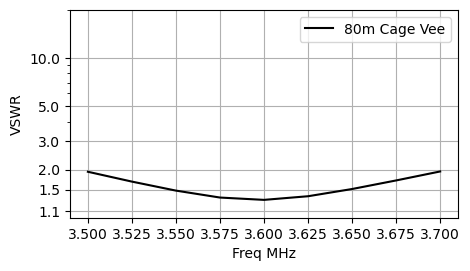

In [43]:


from pymoo.termination import get_termination
from pymoo.optimize import minimize
from pymoo.core.mixed import MixedVariableGA
from pymoo.core.variable import Real, Integer, Choice, Binary


AWG14RADIUS = 1.628/1000/2              # 1.628mm dia
SEGS_PER_M = 10/20.0                    # NEC segments: around 10 for the half-element

class MinWireCageVeeProblem(DipoleConstrainedSingleOptMixedProblem):

    # 'x' is a dictionary containing our parameters 'length','angle','cage_frac','par_wires' 
    def _make_design(self, x):
        half_el = make_linear_element((0,0,0),(0,0.5,0))
        half_el.extend( make_cage_element(0.5, x['length']*x['cage_frac']+0.5, .2, .5, x['par_wires']) )
        half_el.extend( make_linear_element((0,x['length']*x['cage_frac']+0.5,0),(0,x['length'],0)) )
        half_el = rot_x(half_el, np.deg2rad(x['angle']))
        half_el = translate(half_el, (0,0,self.z))
        return half_el

    # Objective to minimize: total wire length
    # Sum total wire length for each design, return as column vector
    def _compute_objective(self, X, designs, zs, vswr_curves, max_vswr):
        return np.array([ total_wire_len(design) for design in designs ])[:,None]
        
    # Constraint: max VSWR must be < 2.0 across freq range
    #  (constraint val must be < 0)
    def _compute_constraints(self, X, designs, zs, vswr_curves, max_vswr):
        return (max_vswr - 2.0)


# Defining our parameters; type and valid ranges
variables = dict()
variables['length'] = Real(bounds=(20.0, 26.0))
variables['angle'] = Real(bounds=(-45.0, 0.0))
variables['cage_frac'] = Real(bounds=(0.1, 1.0))
variables['par_wires'] = Integer(bounds=(2, 10))


mwcvproblem = MinWireCageVeeProblem(variables=variables, n_ieq_constr=1, f_min=3.5, f_max=3.7, z=40,
                                segs_per_m=SEGS_PER_M, radius=AWG14RADIUS)
termination = get_termination("n_gen", 50)
algorithm = MixedVariableGA(pop_size=200, n_offsprings=100)

res = minimize(mwcvproblem, algorithm, termination, save_history=False, verbose=True)

print(f"Optimum length {res.X['length']:.1f}m, angle {res.X['angle']:.1f}deg, cage fraction {res.X['cage_frac']:.2f}, # wires {res.X['par_wires']}, wire length {res.F[0]:.2f}")
vswr_curve = res.pop.get('VSWR')[0]
plot_vswr_2([zip(mwcvproblem.freqs, vswr_curve)], tags=['80m Cage Vee'])

design = mwcvproblem._make_design(res.X)
wire_ant_visualize(design,(-22,22),(-22,22),(0,45))


Result:  total wire length 33.35m versus 46.44m for previous 4-wire cage dipole
![Graph](img/CageVee3_opt.png)